## Batch size-ok összehasonlítása Adam optimizerrel és MSE-loss-szal (10 epoch)



In [1]:
#%% 1. Setup és adatok betöltése
import sys, os
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath(".."))
from complex_mlp.model import ComplexMLP

# Adat betöltése és előkészítés
data = np.load("../data/processed/dataset_preProcessed.npz")
X = data["images"].reshape(len(data["images"]), -1) / 255.0
y = data["labels"]

# Train/validation split
X_tr, X_val, y_tr, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Dinamikus dimenziók
input_dim = X_tr.shape[1]
n_classes = len(np.unique(y_tr))

# Közös modell-beállítások
layer_sizes = [input_dim, 512, n_classes]
activations = ["tanh", "softmax"]
optimizer    = "adam"
opt_kwargs   = {"lr": 5e-4, "beta1": 0.9, "beta2": 0.999, "eps": 1e-8}
loss_fn      = "mse"

# One-hot a MSE-hez
y_tr_hot  = np.eye(n_classes)[y_tr]
y_val_hot = np.eye(n_classes)[y_val]


In [2]:
#%% 2. Batch size-ok listája
batch_sizes = {
    "Stochastic (1)":      1,
    "Mini-batch (32)":     32,
    "Mini-batch (128)":    128,
    "Full batch":          X_tr.shape[0]
}


In [4]:
#%% 3. Futtató ciklus időméréssel
all_results = []

for name, bs in batch_sizes.items():
    print(f"\n=== Teszt: {name}, batch_size={bs} ===")
    model = ComplexMLP(
        layer_sizes=layer_sizes,
        activations=activations,
        loss=loss_fn,
        optimizer=optimizer,
        optimizer_kwargs=opt_kwargs,
        early_stopping=False
    )
    history = {"train_loss": [], "val_loss": [], "epoch_time": []}
    
    epochs = 2
    for ep in range(1, epochs+1):
        t0 = time.time()
        # Shuffle
        idx = np.random.permutation(len(X_tr))
        Xs, ys = X_tr[idx], y_tr_hot[idx]
        
        # Train batch-ek
        tr_loss = 0.0
        for i in range(0, len(Xs), bs):
            xb = Xs[i:i+bs]
            yb = ys[i:i+bs]
            preds = model.forward(xb)
            loss  = model.loss_fn.forward(preds, yb)
            grad  = model.loss_fn.backward()
            model.backward(grad)
            tr_loss += loss * len(xb)
        avg_tr_loss = tr_loss / len(X_tr)
        
        # Validation loss
        vp    = model.forward(X_val)
        vloss = model.loss_fn.forward(vp, y_val_hot)
        
        t1 = time.time()
        elapsed = t1 - t0
        
        # Mentés a history-be
        history["train_loss"].append(avg_tr_loss)
        history["val_loss"].append(vloss)
        history["epoch_time"].append(elapsed)
        
        # Kiírás
        print(f"Epoch {ep}/{epochs}  train_loss={avg_tr_loss:.4f}  "
              f"val_loss={vloss:.4f}  time={elapsed:.2f}s")
    
    # Végső pontosság
    y_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    print(f"→ Final validation accuracy: {acc:.4f}")
    
    all_results.append({
        "batch": name,
        "batch_size": bs,
        "final_accuracy": acc,
        "avg_epoch_time": np.mean(history["epoch_time"])
    })



=== Teszt: Stochastic (1), batch_size=1 ===
Epoch 1/2  train_loss=0.0187  val_loss=0.0140  time=764.68s
Epoch 2/2  train_loss=0.0173  val_loss=0.0144  time=652.66s
→ Final validation accuracy: 0.9111

=== Teszt: Mini-batch (32), batch_size=32 ===
Epoch 1/2  train_loss=0.0166  val_loss=0.0132  time=24.57s
Epoch 2/2  train_loss=0.0122  val_loss=0.0114  time=24.01s
→ Final validation accuracy: 0.9294

=== Teszt: Mini-batch (128), batch_size=128 ===
Epoch 1/2  train_loss=0.0196  val_loss=0.0138  time=7.37s
Epoch 2/2  train_loss=0.0136  val_loss=0.0127  time=7.32s
→ Final validation accuracy: 0.9209

=== Teszt: Full batch, batch_size=54165 ===
Epoch 1/2  train_loss=0.0994  val_loss=0.0686  time=2.35s
Epoch 2/2  train_loss=0.0685  val_loss=0.0474  time=2.29s
→ Final validation accuracy: 0.7256


In [5]:
batch_sizes = {
    "Mini-batch (16)":     16,
    "Mini-batch (32)":     32,
    "Mini-batch (64)":    64,
   
}

In [6]:
for name, bs in batch_sizes.items():
    print(f"\n=== Teszt: {name}, batch_size={bs} ===")
    model = ComplexMLP(
        layer_sizes=layer_sizes,
        activations=activations,
        loss=loss_fn,
        optimizer=optimizer,
        optimizer_kwargs=opt_kwargs,
        early_stopping=False
    )
    history = {"train_loss": [], "val_loss": [], "epoch_time": []}
    
    epochs = 2
    for ep in range(1, epochs+1):
        t0 = time.time()
        # Shuffle
        idx = np.random.permutation(len(X_tr))
        Xs, ys = X_tr[idx], y_tr_hot[idx]
        
        # Train batch-ek
        tr_loss = 0.0
        for i in range(0, len(Xs), bs):
            xb = Xs[i:i+bs]
            yb = ys[i:i+bs]
            preds = model.forward(xb)
            loss  = model.loss_fn.forward(preds, yb)
            grad  = model.loss_fn.backward()
            model.backward(grad)
            tr_loss += loss * len(xb)
        avg_tr_loss = tr_loss / len(X_tr)
        
        # Validation loss
        vp    = model.forward(X_val)
        vloss = model.loss_fn.forward(vp, y_val_hot)
        
        t1 = time.time()
        elapsed = t1 - t0
        
        # Mentés a history-be
        history["train_loss"].append(avg_tr_loss)
        history["val_loss"].append(vloss)
        history["epoch_time"].append(elapsed)
        
        # Kiírás
        print(f"Epoch {ep}/{epochs}  train_loss={avg_tr_loss:.4f}  "
              f"val_loss={vloss:.4f}  time={elapsed:.2f}s")
    
    # Végső pontosság
    y_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    print(f"→ Final validation accuracy: {acc:.4f}")
    
    all_results.append({
        "batch": name,
        "batch_size": bs,
        "final_accuracy": acc,
        "avg_epoch_time": np.mean(history["epoch_time"])
    })


=== Teszt: Mini-batch (16), batch_size=16 ===
Epoch 1/2  train_loss=0.0161  val_loss=0.0127  time=64.40s
Epoch 2/2  train_loss=0.0120  val_loss=0.0103  time=60.25s
→ Final validation accuracy: 0.9362

=== Teszt: Mini-batch (32), batch_size=32 ===
Epoch 1/2  train_loss=0.0165  val_loss=0.0144  time=25.49s
Epoch 2/2  train_loss=0.0123  val_loss=0.0104  time=24.77s
→ Final validation accuracy: 0.9361

=== Teszt: Mini-batch (64), batch_size=64 ===
Epoch 1/2  train_loss=0.0175  val_loss=0.0162  time=13.35s
Epoch 2/2  train_loss=0.0132  val_loss=0.0118  time=12.63s
→ Final validation accuracy: 0.9257


,batch,batch_size,final_accuracy,avg_epoch_time
4,Mini-batch (16),16,0.936198,62.325768
5,Mini-batch (32),32,0.936051,25.130515
1,Mini-batch (32),32,0.929405,24.287950
6,Mini-batch (64),64,0.925713,12.987016
2,Mini-batch (128),128,0.920913,7.347551
0,Stochastic (1),1,0.911091,708.668349
3,Full batch,54165,0.725594,2.321157


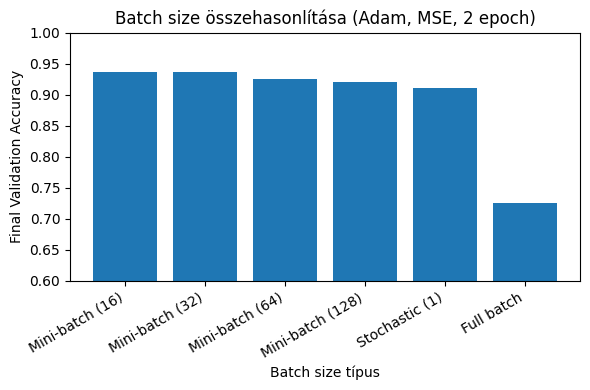

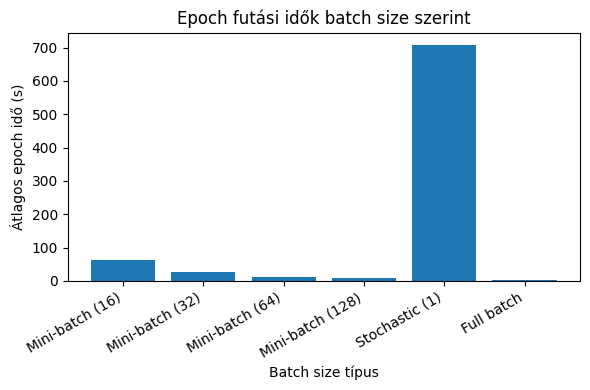

In [9]:
#%% 4. Eredmények összegzése
df = pd.DataFrame(all_results).sort_values("final_accuracy", ascending=False)
display(df)

# Diagram a pontosságokról
plt.figure(figsize=(6,4))
plt.bar(df["batch"], df["final_accuracy"])
plt.xlabel("Batch size típus")
plt.ylabel("Final Validation Accuracy")
plt.title("Batch size összehasonlítása (Adam, MSE, 2 epoch)")
plt.ylim(0.6,1)
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

# Diagram az átlagos epoch-időkről
plt.figure(figsize=(6,4))
plt.bar(df["batch"], df["avg_epoch_time"])
plt.xlabel("Batch size típus")
plt.ylabel("Átlagos epoch idő (s)")
plt.title("Epoch futási idők batch size szerint")
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()


In [10]:
batch_sizes = {
    "Mini-batch (16)":     16,
    "Mini-batch (32)":     32,
    "Mini-batch (64)":    64,
   
}

In [11]:
for name, bs in batch_sizes.items():
    print(f"\n=== Teszt: {name}, batch_size={bs} ===")
    model = ComplexMLP(
        layer_sizes=layer_sizes,
        activations=activations,
        loss=loss_fn,
        optimizer=optimizer,
        optimizer_kwargs=opt_kwargs,
        early_stopping=False
    )
    history = {"train_loss": [], "val_loss": [], "epoch_time": []}
    
    epochs = 10
    for ep in range(1, epochs+1):
        t0 = time.time()
        # Shuffle
        idx = np.random.permutation(len(X_tr))
        Xs, ys = X_tr[idx], y_tr_hot[idx]
        
        # Train batch-ek
        tr_loss = 0.0
        for i in range(0, len(Xs), bs):
            xb = Xs[i:i+bs]
            yb = ys[i:i+bs]
            preds = model.forward(xb)
            loss  = model.loss_fn.forward(preds, yb)
            grad  = model.loss_fn.backward()
            model.backward(grad)
            tr_loss += loss * len(xb)
        avg_tr_loss = tr_loss / len(X_tr)
        
        # Validation loss
        vp    = model.forward(X_val)
        vloss = model.loss_fn.forward(vp, y_val_hot)
        
        t1 = time.time()
        elapsed = t1 - t0
        
        # Mentés a history-be
        history["train_loss"].append(avg_tr_loss)
        history["val_loss"].append(vloss)
        history["epoch_time"].append(elapsed)
        
        # Kiírás
        print(f"Epoch {ep}/{epochs}  train_loss={avg_tr_loss:.4f}  "
              f"val_loss={vloss:.4f}  time={elapsed:.2f}s")
    
    # Végső pontosság
    y_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    print(f"→ Final validation accuracy: {acc:.4f}")
    
    all_results.append({
        "batch": name,
        "batch_size": bs,
        "final_accuracy": acc,
        "avg_epoch_time": np.mean(history["epoch_time"])
    })


=== Teszt: Mini-batch (16), batch_size=16 ===
Epoch 1/10  train_loss=0.0160  val_loss=0.0132  time=46.35s
Epoch 2/10  train_loss=0.0118  val_loss=0.0109  time=35.50s
Epoch 3/10  train_loss=0.0106  val_loss=0.0096  time=44.21s
Epoch 4/10  train_loss=0.0097  val_loss=0.0092  time=36.64s
Epoch 5/10  train_loss=0.0090  val_loss=0.0094  time=39.52s
Epoch 6/10  train_loss=0.0086  val_loss=0.0090  time=34.74s
Epoch 7/10  train_loss=0.0083  val_loss=0.0083  time=45.36s
Epoch 8/10  train_loss=0.0082  val_loss=0.0097  time=35.71s
Epoch 9/10  train_loss=0.0077  val_loss=0.0081  time=40.43s
Epoch 10/10  train_loss=0.0074  val_loss=0.0081  time=35.20s
→ Final validation accuracy: 0.9507

=== Teszt: Mini-batch (32), batch_size=32 ===
Epoch 1/10  train_loss=0.0166  val_loss=0.0142  time=22.58s
Epoch 2/10  train_loss=0.0125  val_loss=0.0122  time=20.93s
Epoch 3/10  train_loss=0.0106  val_loss=0.0100  time=19.86s
Epoch 4/10  train_loss=0.0096  val_loss=0.0096  time=22.66s
Epoch 5/10  train_loss=0.0088